# Problem Statement

Aim of this exercise is to get initial insights of the market segment dataset and cluster customers using Hierarchical clustering algorithm so that appropriate action can be recommended on each segment and improve the business performance.

### Methodology
Model development is divided into multiple steps as mentioned below,
- Data exploring and understanding: This step involves preliminary level data understanding and exploring.
- Data Cleaning: This step includes cleaning the existing data. We check the data for any missing values and treat them as per the requirements. We also need to look for constant value colulmns as that is not going to add any additional value to out analysis. Sometimes columns with very high proportion of any particular value also doesn't add any values. Hence, getting rid of them helps with further analysis.
- Data Visualization: This step involves visualizing our dataset and check for relationship amongst independent variables. We can also reduce some feature columns here but it should not be aggressive.
- Data Preparation: This step is mainly usefull for feeding in the data into the model. It involves steps like creating dummy variables, scaling etc. depending upond the data type.
- Model Development-validation and evaluaiton: This steps involves training the model and validate it. It involves evaluating the model using relevant matrics.
- Conclusion/Recommendation: It involves drawing conclusions and recommendations to business.

### Dependancies

In [1]:
# Dependancies

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings('ignore')

### Reading Dataset

In [2]:
data = pd.read_csv('Mall_Customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Data is having 200 entries and 5 columns. It includes 4 numeric and 1 categorical columns.

- CustomerID: Unique customer ID
- Gender: Customer gender
- Age: Age of the customer
- Annual Income (k$): Customer's annual income
- Spending score (1-100): Score depending upon purchasing behaviour and past data. Range is 1-100.

## 1. Data Exploration and Understanding

In [4]:
# Customer ID

data.CustomerID.nunique()

200

There are 200 unique entries that means each customer is unique in the dataset.

<AxesSubplot:ylabel='Gender'>

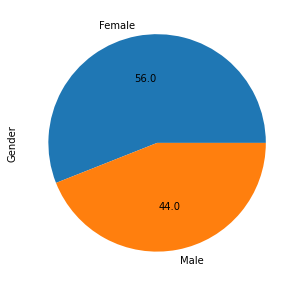

In [5]:
# Gender

data.Gender.value_counts().plot.pie(figsize=(5, 5), autopct="%1.1f")

Customer share for female customers is little higher than male. 

<AxesSubplot:xlabel='Age', ylabel='Density'>

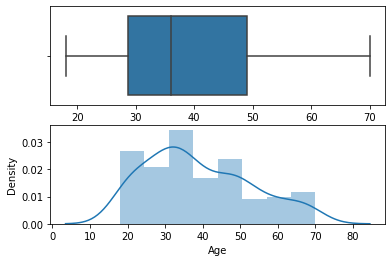

In [6]:
# Age

plt.subplot(2,1,1)
sns.boxplot(data.Age)
plt.subplot(2,1,2)
sns.distplot(data.Age)

Median age of the customers is ~36 yrs. There are no outliers in this column. The distribution looks almost normal.

In [7]:
# rename few columns for convenience of access

data = data.rename(columns={'Annual Income (k$)':'an_inc', 'Spending Score (1-100)': 'spend_score'})
data.head()

,CustomerID,Gender,Age,an_inc,spend_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<AxesSubplot:xlabel='an_inc', ylabel='Density'>

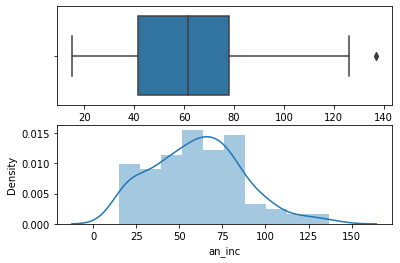

In [8]:
# an_inc

plt.subplot(2,1,1)
sns.boxplot(data.an_inc)
plt.subplot(2,1,2)
sns.distplot(data.an_inc)

Median annual income is around $60k. We observe few outliers in this columns but they aren't large in number. The distribution doesn't look normal.

<AxesSubplot:xlabel='spend_score', ylabel='Density'>

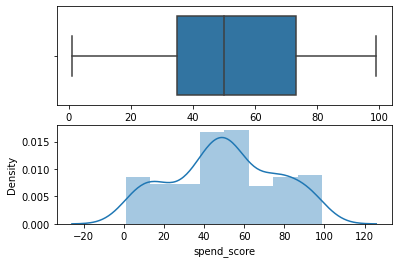

In [9]:
# spend_score

plt.subplot(2,1,1)
sns.boxplot(data.spend_score)
plt.subplot(2,1,2)
sns.distplot(data.spend_score)

Median spend score is around 50. We observe no outliers in this column. The distribution doesn't look normal.

## 2. Data Cleaning

Dataset is having no null entries and also minimal outliers. Hence, we are going to skip this step.

## 3. Data Visualization

<AxesSubplot:>

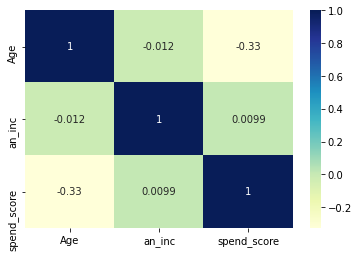

In [10]:
# numeric columns

num_cols = data.select_dtypes(['int64', 'float64']).columns

# removing ID columns 
num_cols = num_cols.drop('CustomerID')

# Heatmapping the correlation

sns.heatmap(data[num_cols].corr(), annot=True, cmap='YlGnBu')

We dont observe any strong relation between numeric data columns here.

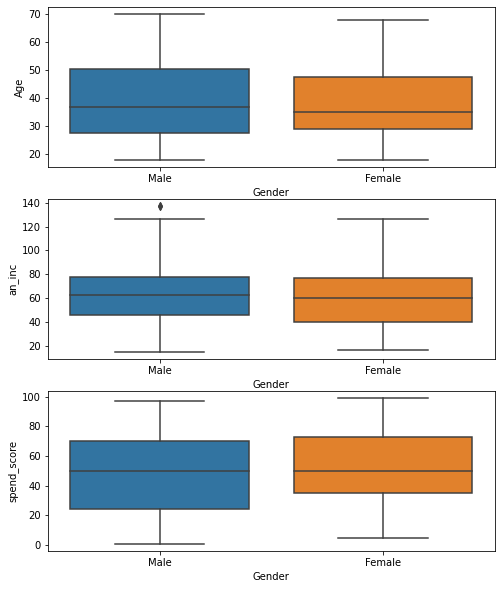

In [11]:
# cat_cols vs num_cols
plt.subplots(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(num_cols.shape[0], 1, i+1)
    sns.boxplot(x=data['Gender'], y=data[col])
    

Observations,
- Male customers have little higher median age as compared to female with wider spread.
- Male customers have higher median annual income as compared to female.
- Female customers have better median spending score as compared to male.

## 4. Data Preparation

For Hierarchical clustering, we would only use numeric data columns as it would use euclidian distance to develop clusters.

In [12]:
# use StandardScaler for num_cols 

scaler = StandardScaler()

data_s= scaler.fit_transform(data[num_cols])

data_s = pd.DataFrame(data_s, columns=num_cols)
data_s.head()

,Age,an_inc,spend_score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


## 5. Model Development-validation and evaluation

Hierarchical clustering can be done using two ways, `Agglomerative` and `Divisive`. 
- `Agglometative` clustering includes combining similar data entries based on similarity score. It is a bottom to top approach.
- `Divisive` clustering includes dividing the whole dataset into fragments from top to bottom.

Here, we are going to use `Agglomerative` clustering technique.

We would be exploring the cluster results with two different submethod for linking the data entries viz, `Complete Linkage` and `Average linkage`.
`Complete Linkage` combines data entries/clusters based in farthest data points between them, whereas `Average Linkage` compares them combines using avarage value of the distance.

### Complete Linkage based clustering

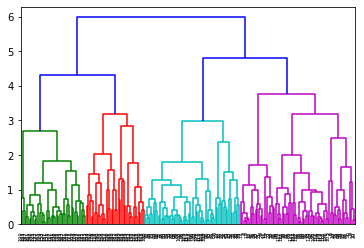

In [13]:
# complete linkage

agglo_clus_com = linkage(data_s, method='complete')
dendrogram(agglo_clus_com)
plt.show()

We can observe there are 4 possible major clusters by using `complete linkage`. Hence, we would be diving the data into 4 clusters and try to understand each cluster.

In [14]:
# Cut the dendogram at 4 clusters

cluster_labels = cut_tree(agglo_clus_com, n_clusters=4).reshape(-1, )
data['cluster_labels_complete'] = cluster_labels
data.head()

,CustomerID,Gender,Age,an_inc,spend_score,cluster_labels_complete
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0


#### Understanding the clusters (complete linkage)

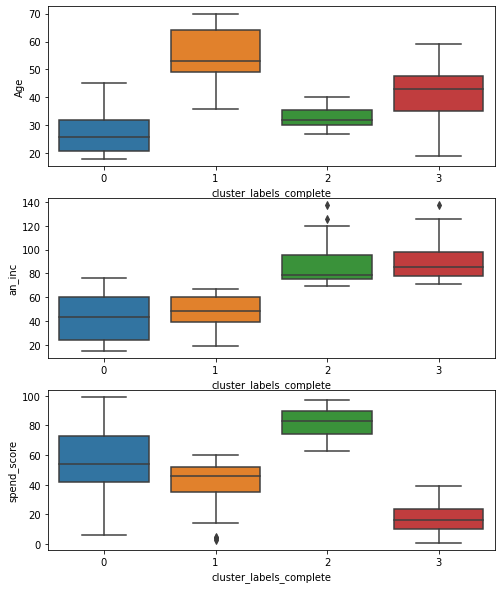

In [15]:
plt.subplots(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(num_cols.shape[0], 1, i+1)
    sns.boxplot(x='cluster_labels_complete', y=col, data=data)

Observations:

- Cluster 0: It is medium spending score cluster with moderate annual income and higher age.
- Cluster 1: It is above moderate spending score cluster with lower income and relatively young customers.
- Cluster 2: These customers have very high spending score and higher income with moderately young.
- Cluster 3: These are lowest spending score customers with higher annual income and mid aged.

### Average Linkage based clustering

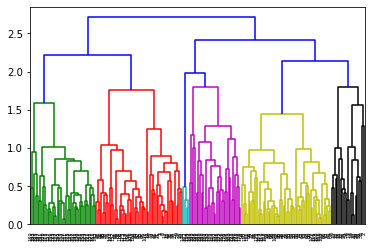

In [16]:
# average linkag

agglo_clus_avg = linkage(data_s, method='average')
dendrogram(agglo_clus_avg)
plt.show()

We can observe there are 5 possible major clusters by using `average linkage`. Hence, we would be diving the data into 5 clusters and try to understand each cluster.

In [17]:
# Cut the dendogram at 5 clusters

cluster_labels = cut_tree(agglo_clus_avg, n_clusters=5).reshape(-1, )
data['cluster_labels_average'] = cluster_labels
data.head()

,CustomerID,Gender,Age,an_inc,spend_score,cluster_labels_complete,cluster_labels_average
0,1,Male,19,15,39,0,0
1,2,Male,21,15,81,0,1
2,3,Female,20,16,6,0,0
3,4,Female,23,16,77,0,1
4,5,Female,31,17,40,0,0


#### Understanding the clusters (average linkage)

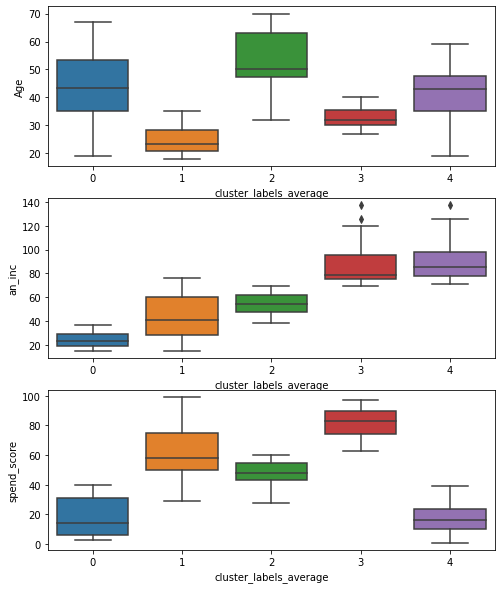

In [18]:
plt.subplots(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(num_cols.shape[0], 1, i+1)
    sns.boxplot(x='cluster_labels_average', y=col, data=data)

Observations:

- Cluster 0: It is low spendimg score cluster with low annual income and higher age.
- Cluster 1: It is above moderate spending score cluster with medium income and relatively young customers.
- Cluster 2: These customers have moderate spending score and moderate income with relatively older.
- Cluster 3: These are highest spending score customers with high annual income and mid aged.
- Cluster 4: These are lowest spending score customers with very high annual income and mid aged.

This is relatively better as compared to complete linkage based seggregation in terms of finding out target groups to focus on from improving the spending score perspective.

#### Silhouette Score

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

Where,
$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [19]:
silhouette_com = silhouette_score(data[num_cols], data['cluster_labels_complete'])
silhouette_avg = silhouette_score(data[num_cols], data['cluster_labels_average'])

print('Silhouette Score complete linkage:', silhouette_com)
print('Silhouette Score average linkage:', silhouette_avg)

Silhouette Score complete linkage: 0.3653446919934641
Silhouette Score average linkage: 0.4168071489715156


Silhouette Score using `Average linkage` is better as compared to `Complete linkage`  in this case.

## 6. Conclusion/Recommendation

**Conclusion**: Hierarchical clustering methods are developing 4/5 clusters in the dataset. These clusters are showing variation in annual income, age and gender.

**Recommendation** : 
- Lower spending score customers with higher annual income belongs to moderate age. This cluster(avg link=cluster4) can be targeted with attractive offers suitable to their needs.
- Lower spending customers (avg link=cluster0) with lower income and highers age should be provided with discout offers and credit services so that they can offord more. These might be retired population.

-----------